In [1]:
import numpy as np
import cv2
import os
import glob
import time
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D
from skimage.feature import hog

from sklearn.preprocessing import StandardScaler

from random import randint

from tools import convert_color
from tools import get_hog_features
from tools import extract_features
from tools import slide_window
from tools import draw_boxes
from tools import search_windows
from tools import find_cars
from display_tools import displayDifferentHOG

Vehicle images: 8792
Non vehicle images: 8968


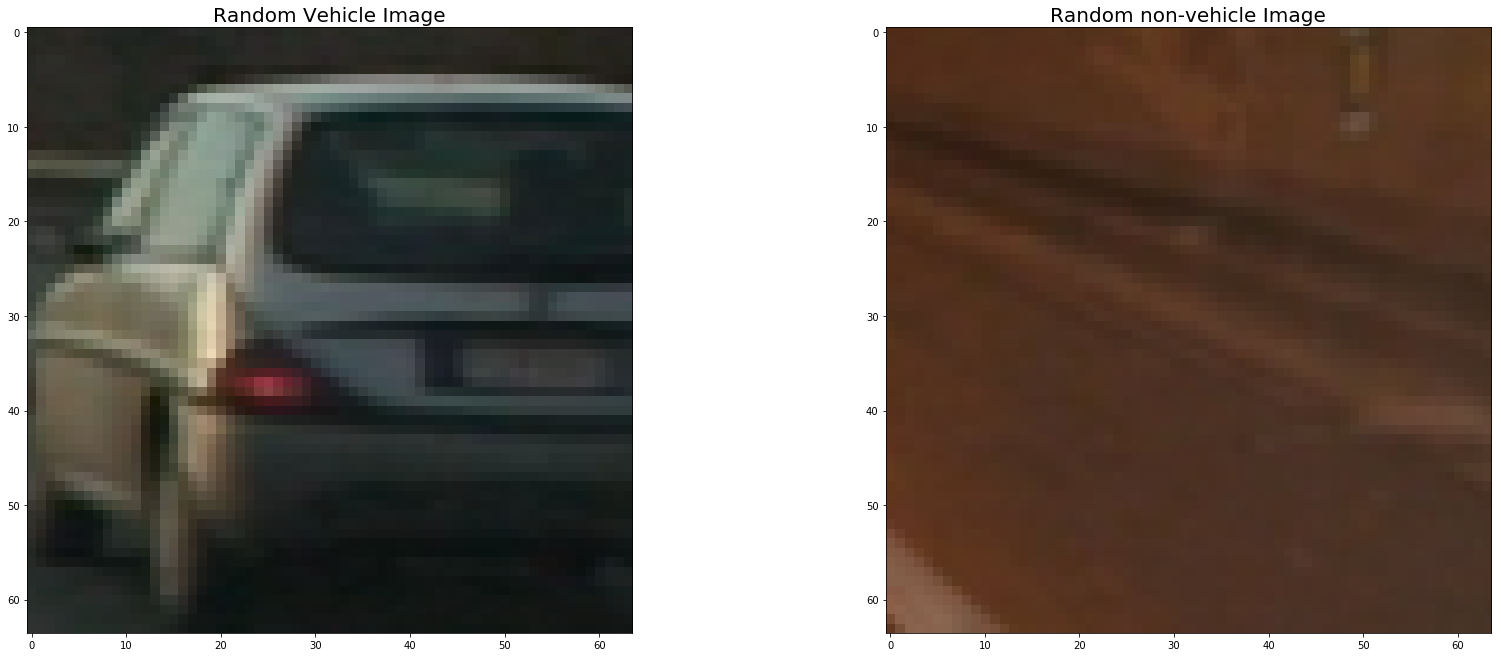

In [2]:
# Define the different global parameters
test_images = os.listdir('test_images/')
test_images_folder = 'test_images/'
output_folder = 'output_images'

# get the vehicle and non-vehicle images from the training data set 
veh_images = glob.glob('training_images/vehicles/**/*.png')
nonveh_images = glob.glob('training_images/non-vehicles/**/*.png')

ystart = 400
ystop = 656
scale = 1.5

print('Vehicle images: ' + str(len(veh_images)))
print('Non vehicle images: ' + str(len(nonveh_images)))

vehicle = mpimg.imread(veh_images[randint(0, len(veh_images))]);
non_vehicle = mpimg.imread(nonveh_images[randint(0, len(nonveh_images))])


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(vehicle)
ax1.set_title('Random Vehicle Image', fontsize=20)
ax2.imshow(non_vehicle)
ax2.set_title('Random non-vehicle Image', fontsize=20)


C:\Users\Sorina\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:248: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


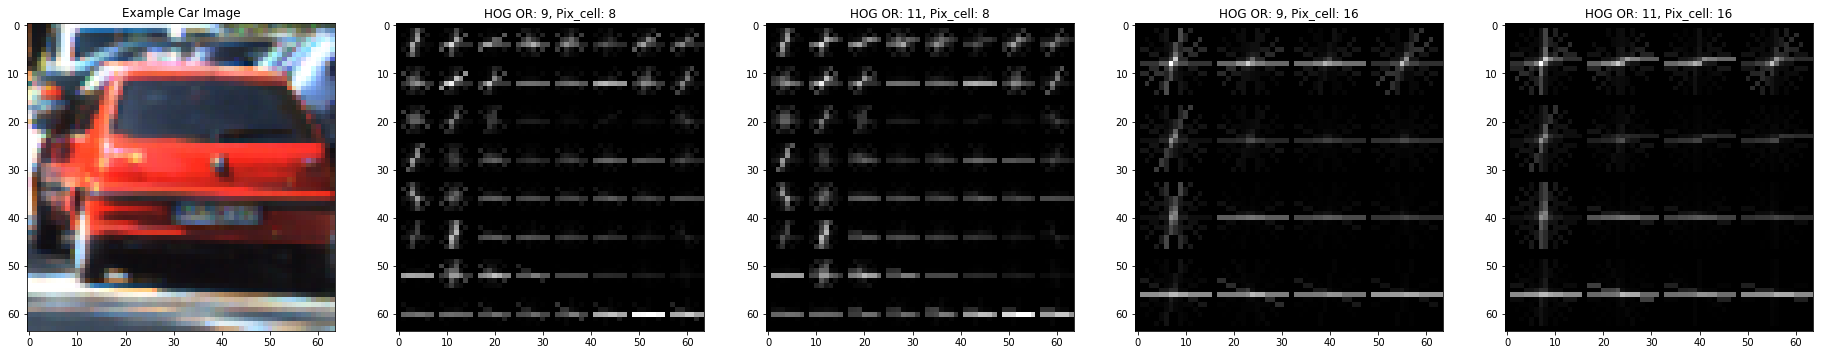

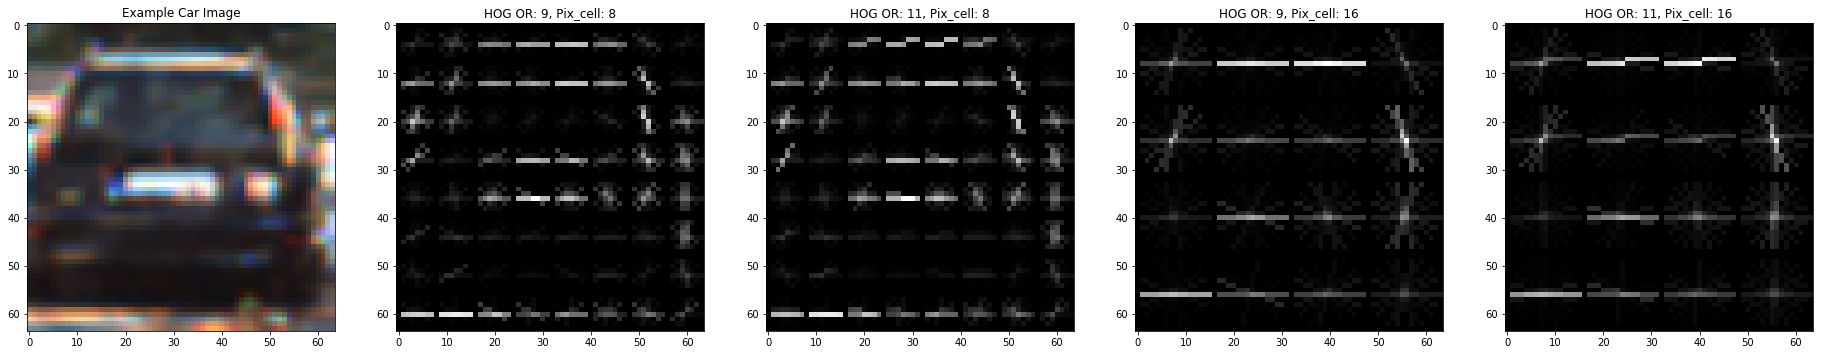

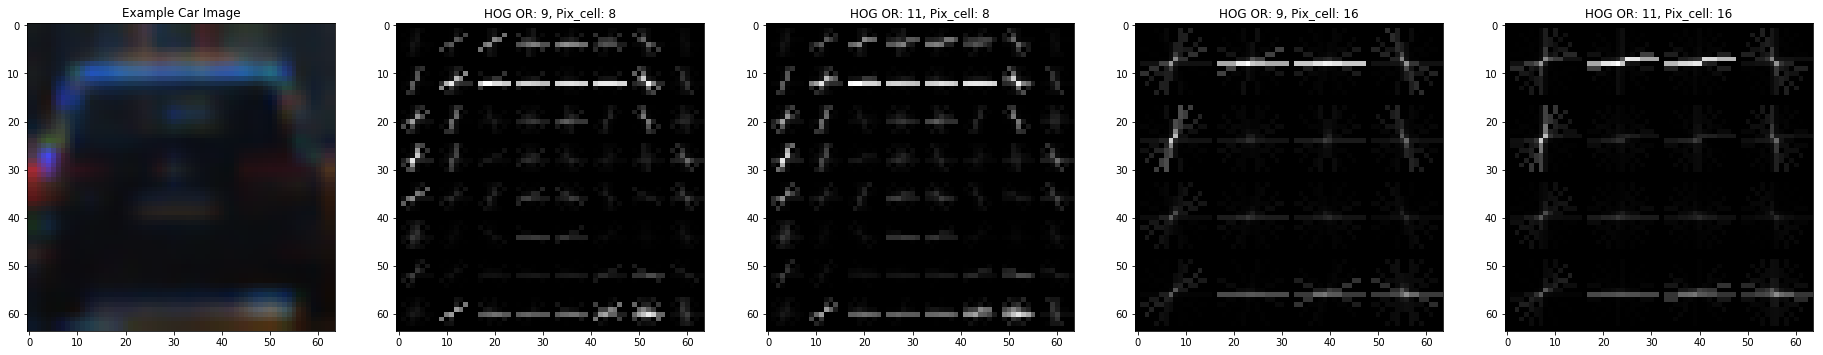

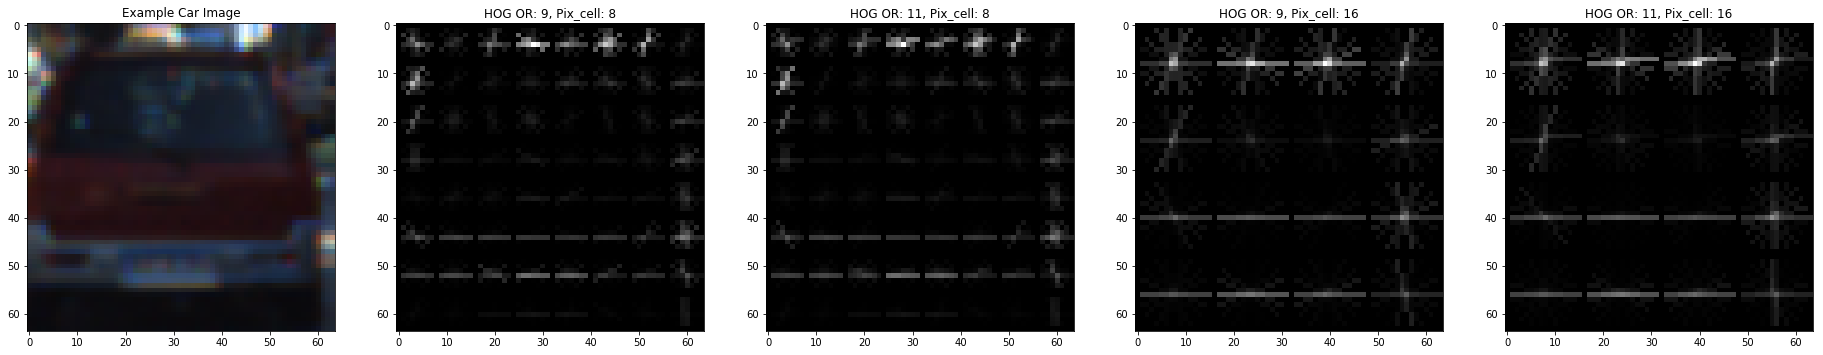

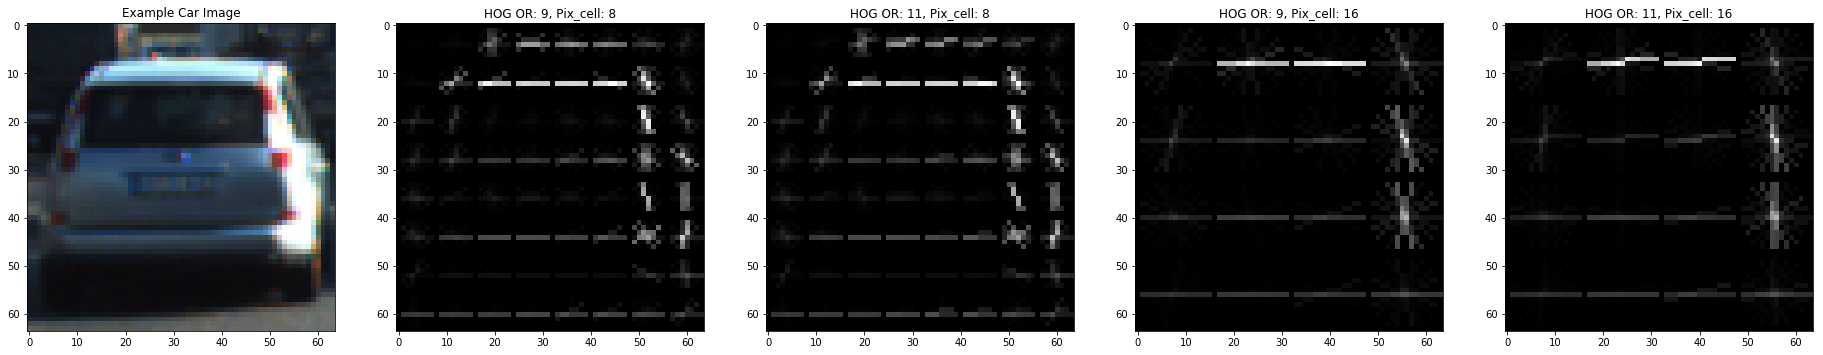

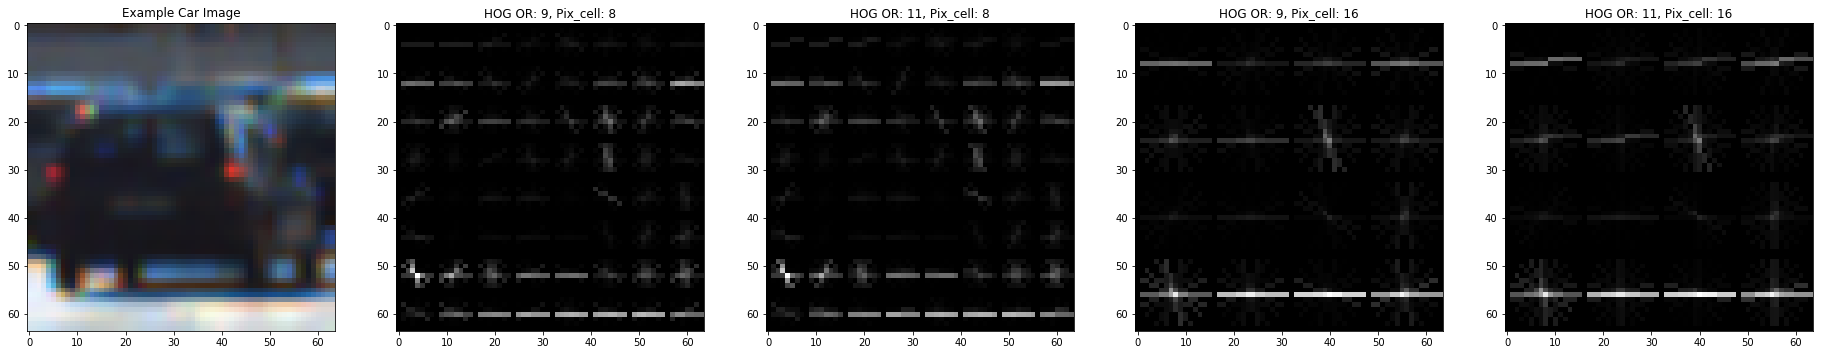

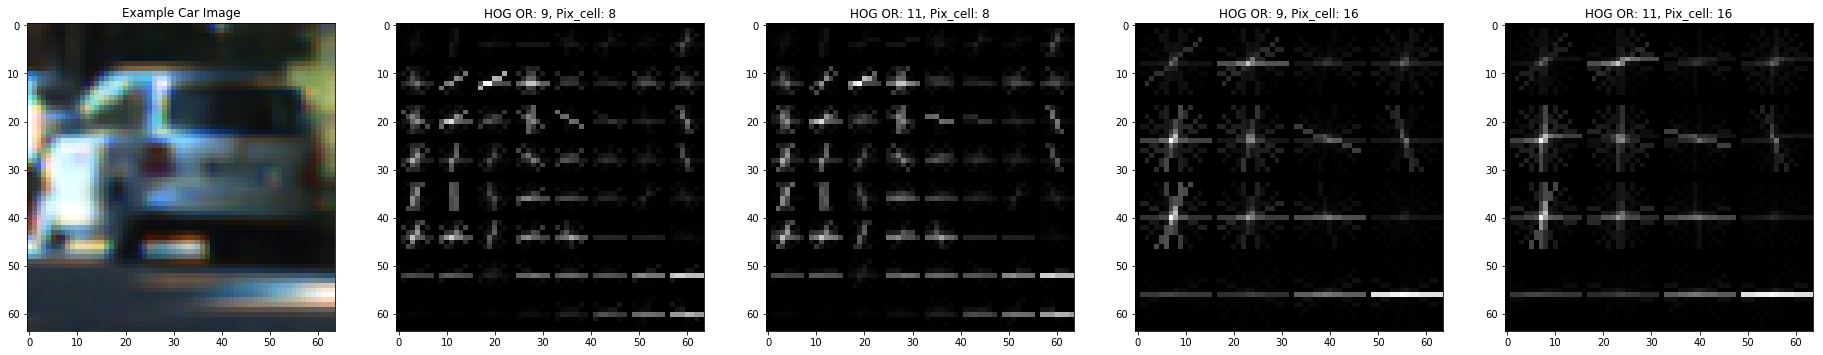

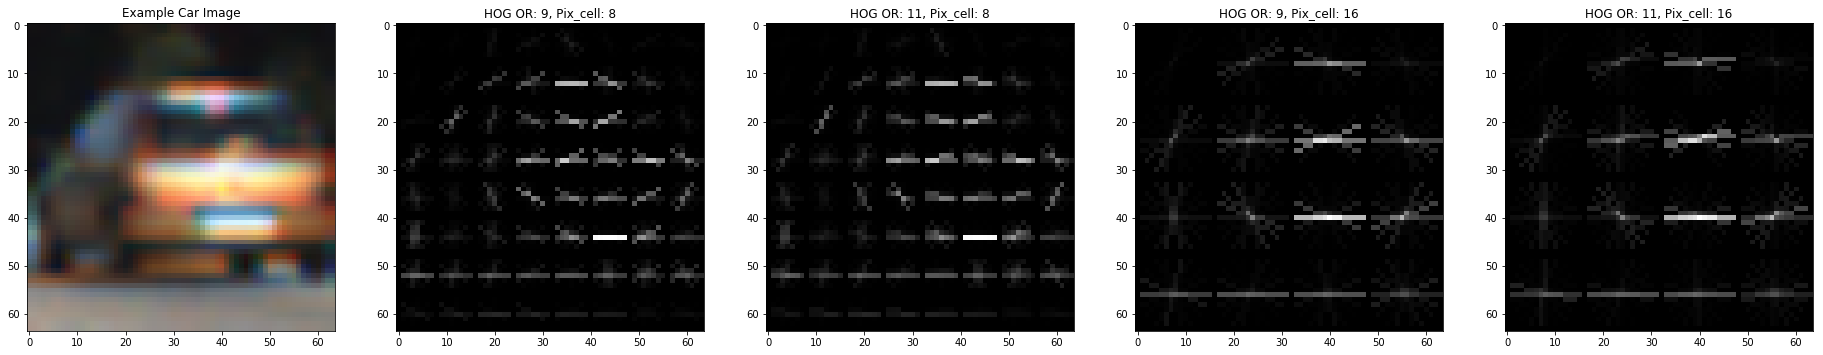

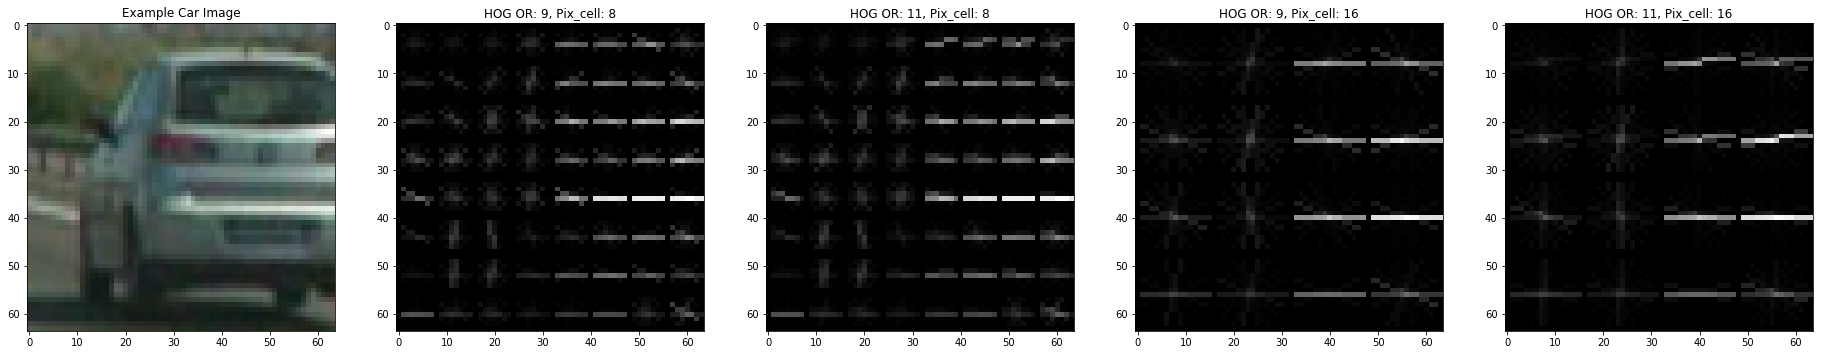

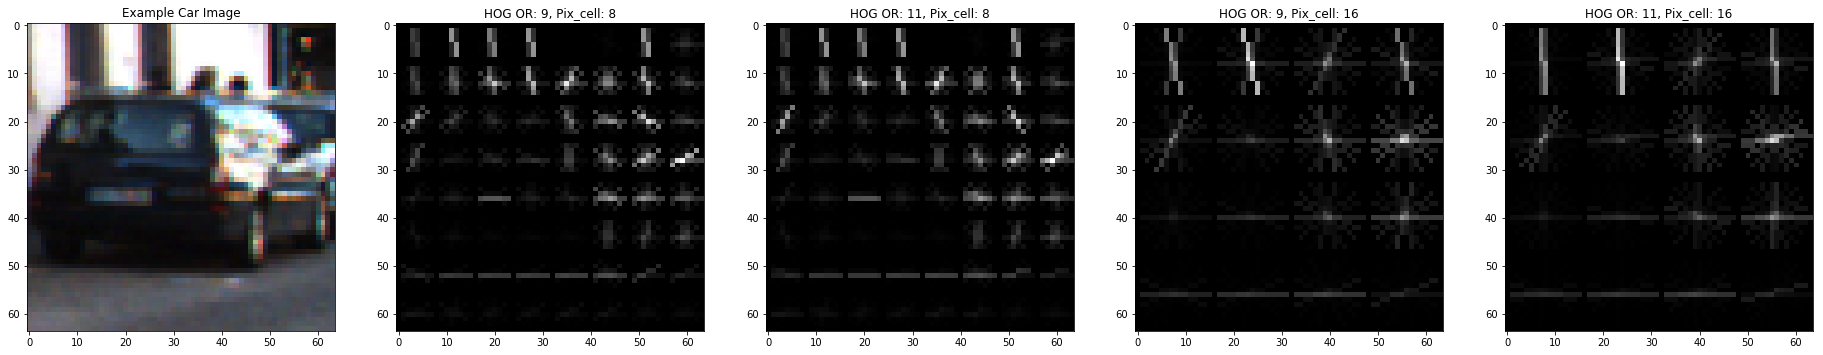

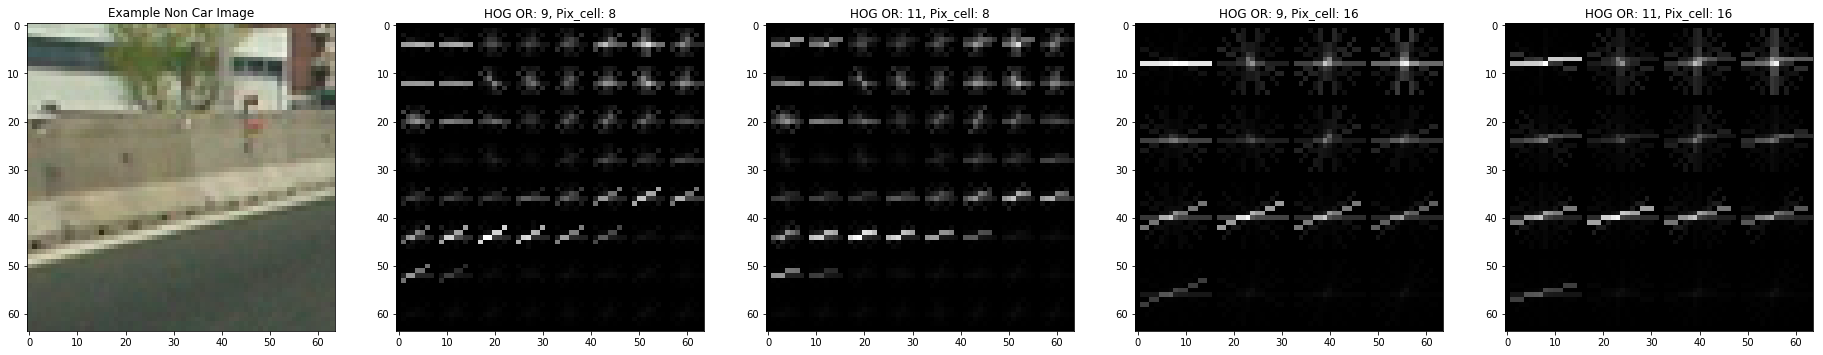

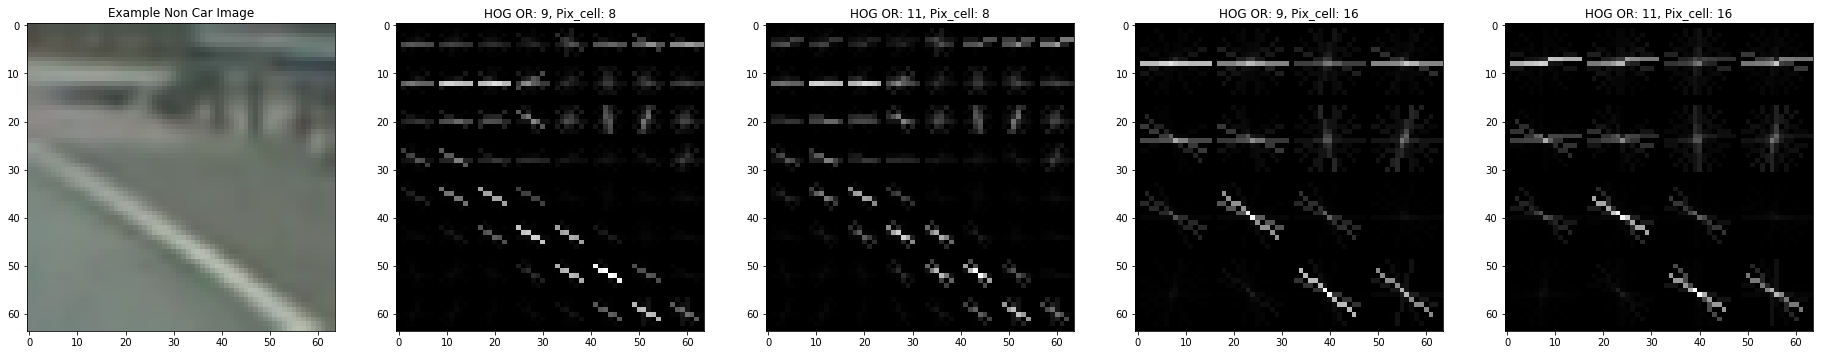

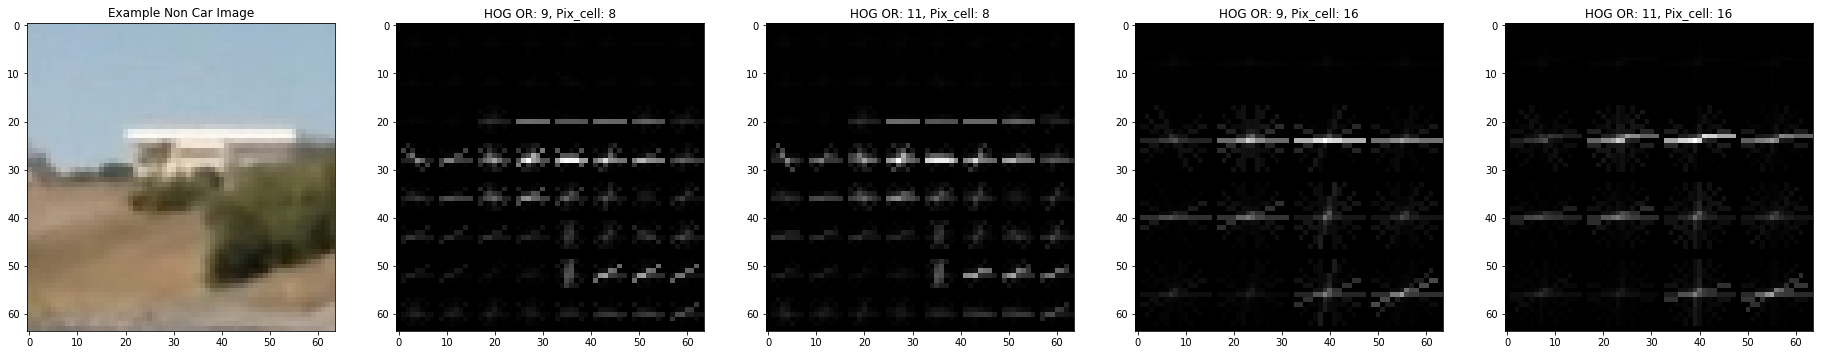

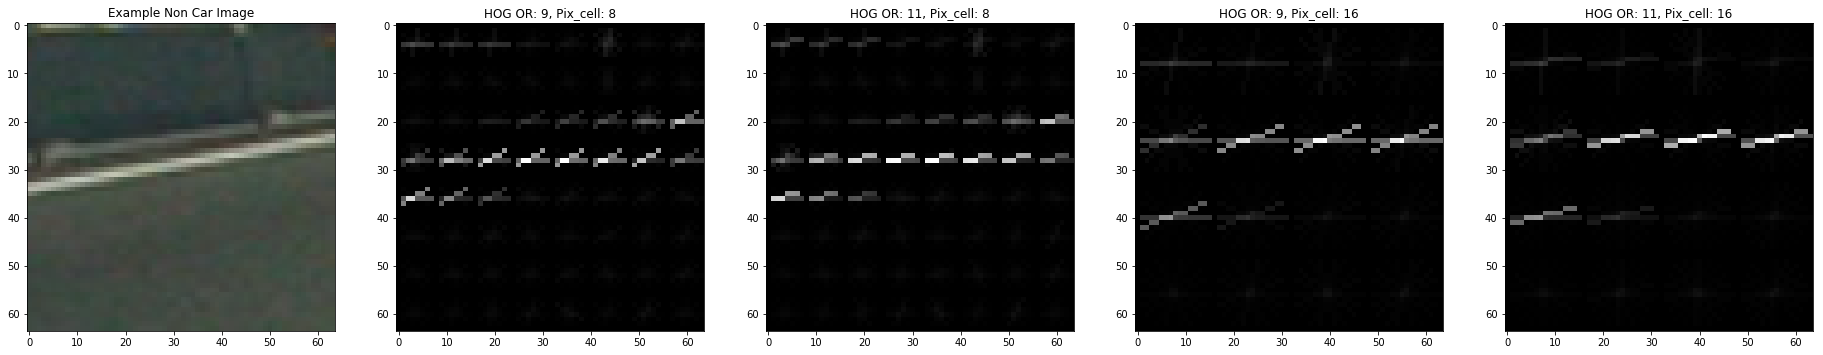

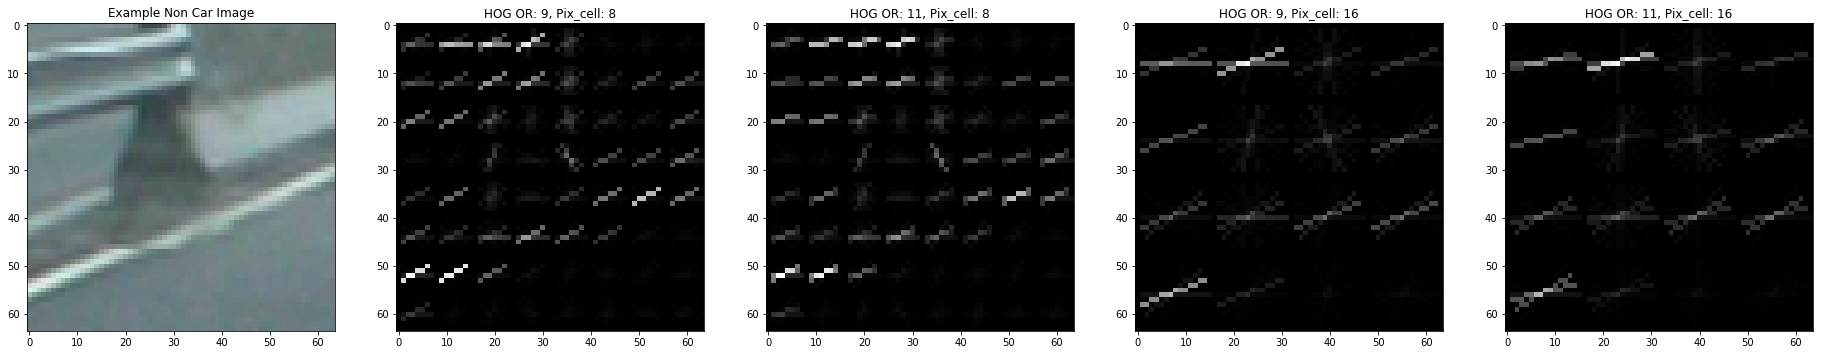

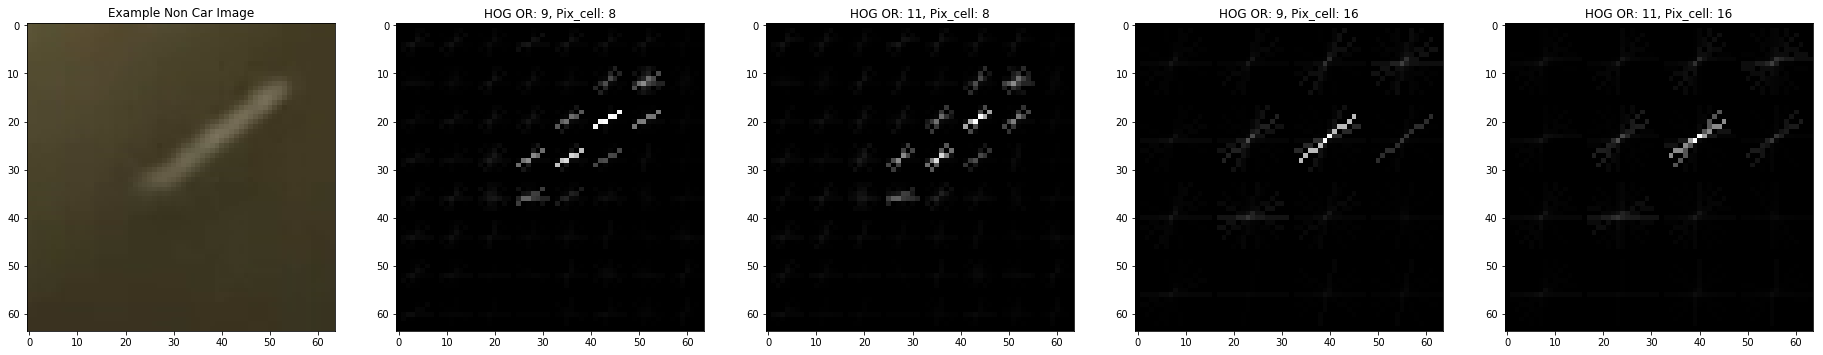

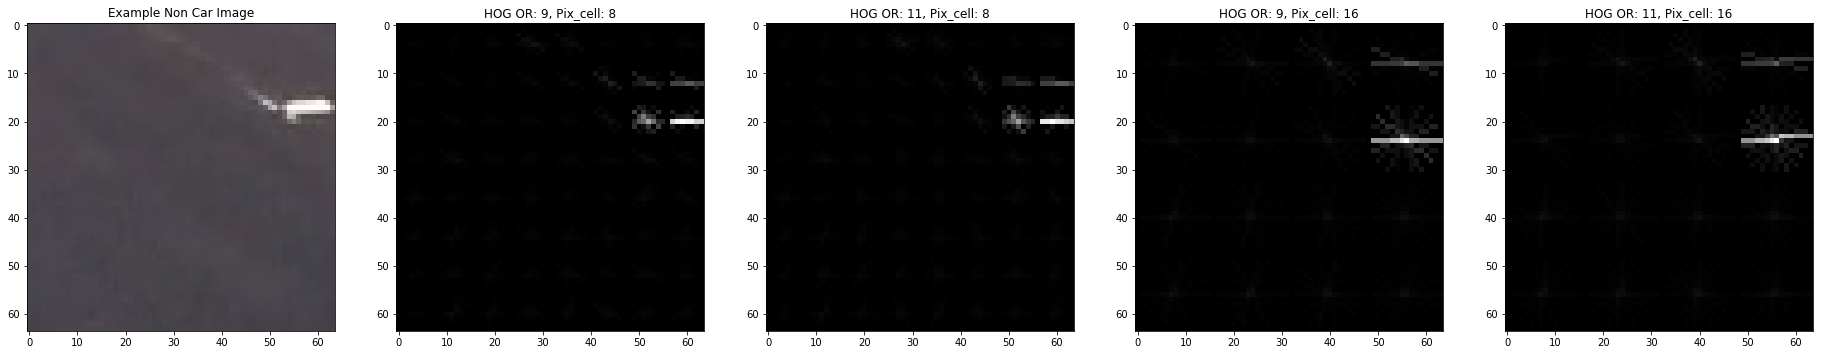

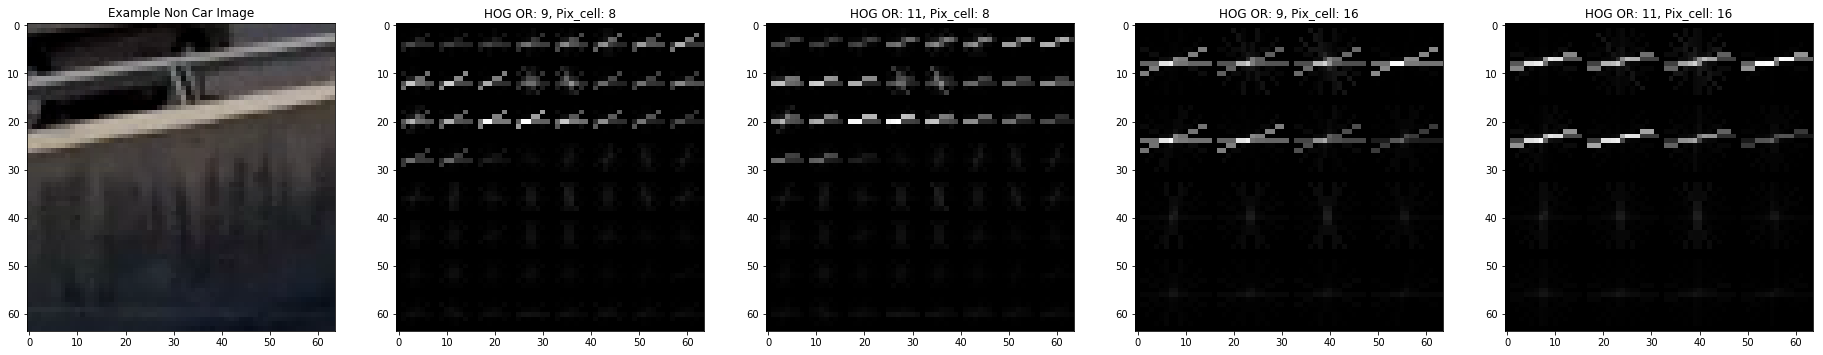

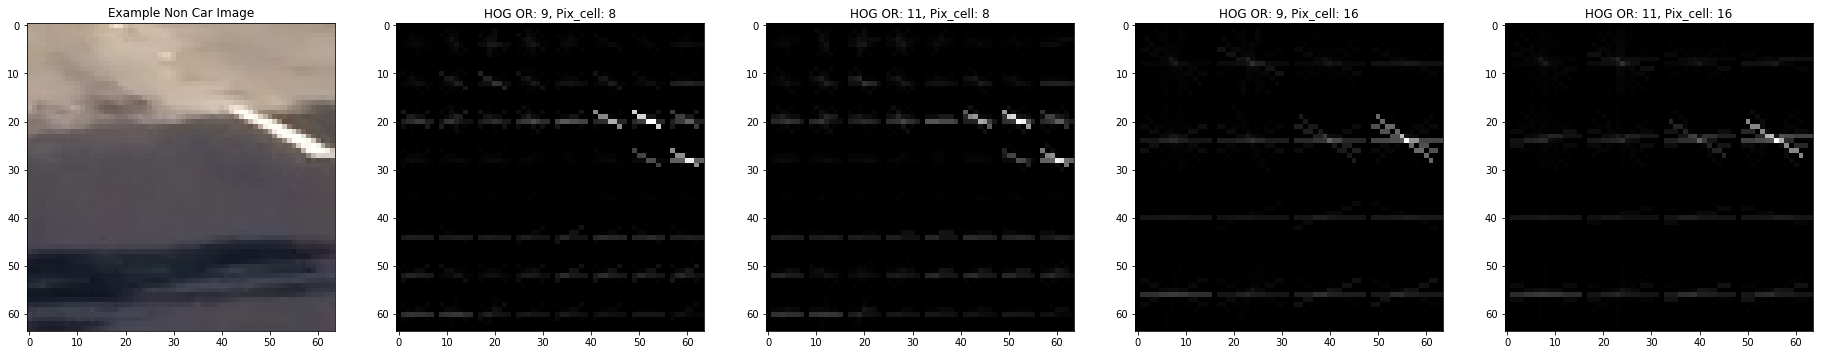

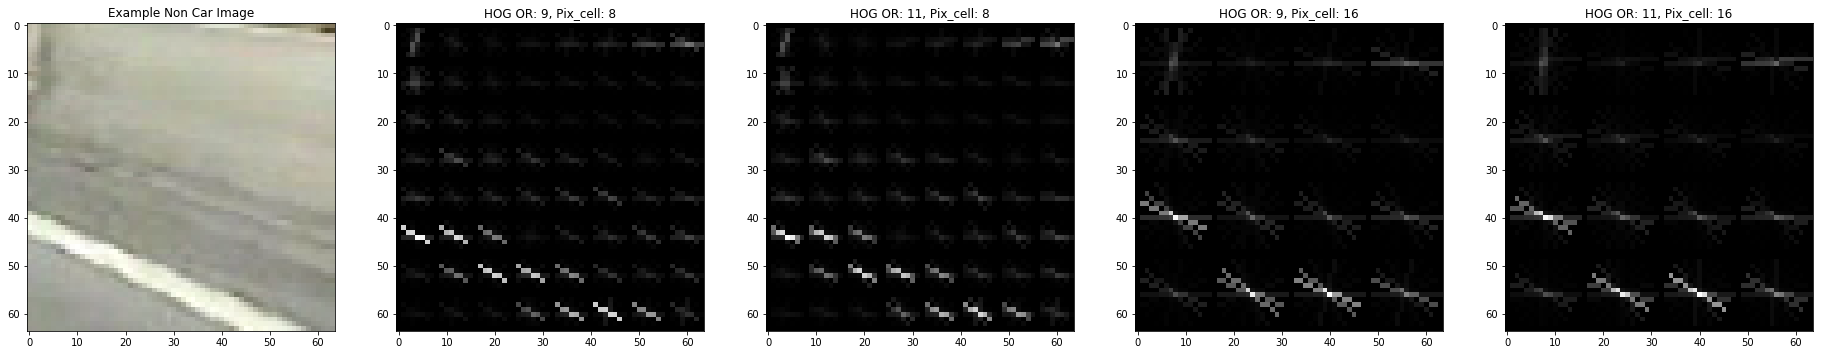

In [3]:
# Read in random images and display them with different HOG
displayDifferentHOG(veh_images, nonveh_images)


In [25]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn import tree
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split



### After extensive testing of different parameter combinations, the following have been selected
color_space = 'YCrCb' 
orient = 11  # HOG orientations
pix_per_cell = 16 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" 
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [None, None] # Min and max in y to search in slide_window()

car_features = extract_features(veh_images, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(nonveh_images, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)
    
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Using:',color_space,'color space',orient,'orientations',pix_per_cell,
                        'pixels per cell and', cell_per_block,'cells per block', 
                          hog_channel, 'hog channel', spatial_size, 'spatial size', 
                         hist_bins, 'hist bins')
print('Feature vector length:', len(X_train[0]))

# Use a linear SVC 
svc = LinearSVC(C=0.0001)

# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()



Using: YCrCb color space 11 orientations 16 pixels per cell and 2 cells per block ALL hog channel (32, 32) spatial size 16 hist bins
Feature vector length: 4308
5.72 Seconds to train SVC...
Test Accuracy of SVC =  0.9916


In [ ]:
# After choosing the correct tunning parameters, a search for the best parameters for the LinearSVC is made
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score

parameters = {
    'C': [0.0001, 0.1, 10, 100]
}

f1_scorer = make_scorer(f1_score)

grid_obj = GridSearchCV(svc, 
                        param_grid=parameters,
                        scoring=f1_scorer)

grid_obj.fit(X_train, y_train)

clf = grid_obj.best_estimator_
y_preds = clf.predict(X_test)
f1 = f1_score(y_test, y_preds)
print('Accuracy score: ', f1)
print(clf)

In [46]:
# saving the model and parameters
import pickle

data={
    'svc': svc,
    'X_scaler': X_scaler,
    'color_space': color_space,
    'orient': orient,
    'pix_per_cell': pix_per_cell,
    'cell_per_block': cell_per_block,
    'spatial_size' : spatial_size,
    'hist_bins': hist_bins,
    'hog_channel': hog_channel,
    'car_features': car_features,
    'notcar_features': notcar_features,
    'X_train': X_train,
    'X_test': X_test,
    'y_train': y_train,
    'y_test': y_test
     }

file = open("./data_exports/parameters_YCrCb_2.p", "wb")
pickle.dump(data, file)
file.close()

In [5]:
# import model and parameters from file
import pickle
with open('./data_exports/parameters_YCrCb_1.p', 'rb') as f:
    x = pickle.load(f)
    
color_space = x['color_space']
orient = x['orient'] 
pix_per_cell = x['pix_per_cell']
cell_per_block = x['cell_per_block']
spatial_size  =  x['spatial_size']
hist_bins =  x['hist_bins']
hog_channel = x['hog_channel']
car_features = x['car_features']
notcar_features = x['notcar_features']
X_scaler = x['X_scaler']
X_train = x['X_train']
X_test = x['X_test']
y_train = x['y_train']
y_test = x['y_test']

svc = x['svc']

spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [None, None]

In [6]:
from sklearn import tree
from sklearn.svm import LinearSVC
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression


clf1 = LogisticRegression(random_state=1)

clf = tree.DecisionTreeClassifier(criterion="entropy", max_depth=1)
svc = LinearSVC(C=0.1)
svc.probability = True

eclf1 = VotingClassifier(estimators=[('svc', svc), ('clf1', clf1)], voting='hard')

# Check the training time for the SVC
t=time.time()
eclf1.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
acc=eclf1.score(X_test, y_test)
print('Test Accuracy of SVC = ', round(acc, 4))
# Check the prediction time for a single sample
t=time.time()

46.21 Seconds to train SVC...
Test Accuracy of SVC =  0.9851


C:\Users\Sorina\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:248: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


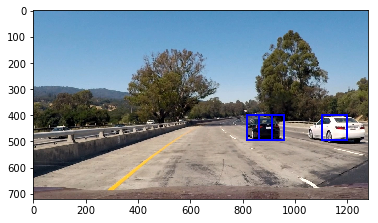

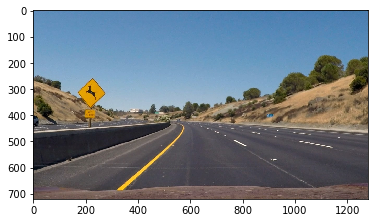

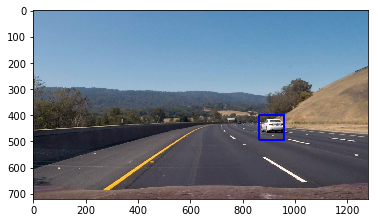

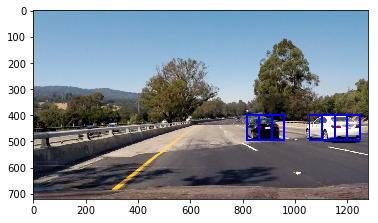

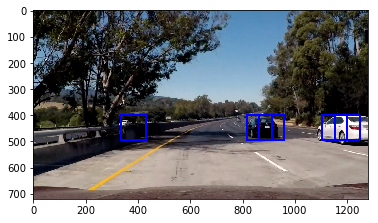

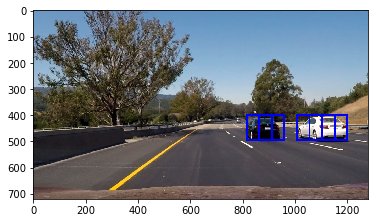

In [13]:
for path in test_images:
    image = mpimg.imread(test_images_folder + path)
    draw_image = np.copy(image)
    image = image.astype(np.float32)/255
    
    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[ystart, ystop], 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))
    
    
    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

    plt.imshow(window_img)
    plt.show()

In [6]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img


C:\Users\Sorina\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:248: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


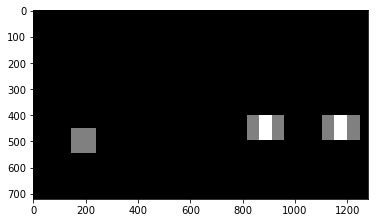

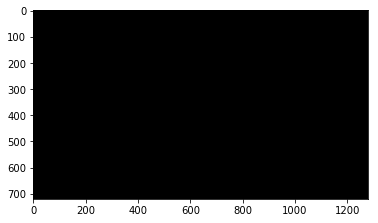

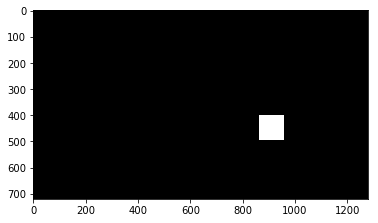

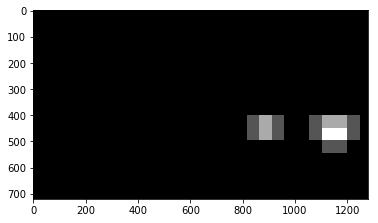

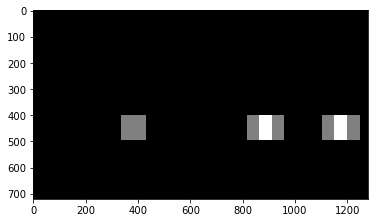

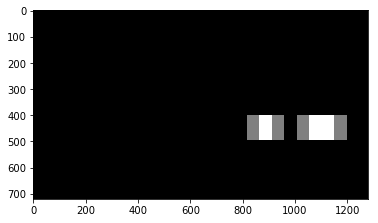

In [16]:
from scipy.ndimage.measurements import label

for path in test_images:
    image = mpimg.imread(test_images_folder + path)
    
    bboxes = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, hog_channel)
    
    heat = np.zeros_like(image[:,:,0])

    # Add heat to each box in box list
    heat = add_heat(heat,bboxes)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 0.5)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)

    plt.imshow(heatmap, cmap='gray')
    plt.show()

In [30]:
def process_frame(image):
    
    bboxes = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, hog_channel)
    
    heat = np.zeros_like(image[:,:,0])

    # Add heat to each box in box list
    heat = add_heat(heat,bboxes)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,0.5)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    return draw_img
    

In [31]:
from moviepy.editor import VideoFileClip
test_out_file = 'output_videos/project_video_YCrCb_1.mp4'
clip_test = VideoFileClip('project_video.mp4')
clip_test_out = clip_test.fl_image(process_frame)
%time clip_test_out.write_videofile(test_out_file, audio=False)

[MoviePy] >>>> Building video output_videos/project_video_YCrCb_1.mp4
[MoviePy] Writing video output_videos/project_video_YCrCb_1.mp4


100%|█████████████████████████████████████▉| 1260/1261 [06:00<00:00,  3.49it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video_YCrCb_1.mp4 

Wall time: 6min 1s
